- https://karpathy.github.io/2016/05/31/rl/

In [9]:
import numpy as np
import pickle
import gymnasium as gym
import ale_py
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

In [10]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

In [11]:
def sigmoid(x):
    x = np.clip(x, -30, 30) #?
    return 1.0 / (1.0 + np.exp(-x))

def prepro(I):
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float64).ravel()

def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h < 0] = 0 #Relu noice
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h

def policy_backward(eph, epdlogp, epx):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    return {'W1': dW1, 'W2': dW2}


def save_checkpoint(filename, is_best=False):
    checkpoint = {
        'model': model,
        'rmsprop_cache': rmsprop_cache,
        'running_reward': running_reward,
        'episode_number': episode_number,
        'best_reward': best_reward
    }
    pickle.dump(checkpoint, open(filename, 'wb'))
    if is_best:
        pickle.dump(checkpoint, open(best_save_file, 'wb'))

In [12]:
D = 80 * 80
save_file = 'pong_model.p'
best_save_file = 'pong_model_best.p'

if resume and os.path.exists(save_file):
    print(f"Loading model from {save_file}")
    checkpoint = pickle.load(open(save_file, 'rb'))
    model = checkpoint['model']
    rmsprop_cache = checkpoint['rmsprop_cache']
    running_reward = checkpoint['running_reward']
    episode_number = checkpoint['episode_number']
    best_reward = checkpoint.get('best_reward', -21)
    print(f"Resumed at episode {episode_number}, running reward: {running_reward:.2f}")
else:
    model = {}
    model['W1'] = np.random.randn(H, D) / np.sqrt(D)
    model['W2'] = np.random.randn(H) / np.sqrt(H)
    rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}
    running_reward = None
    episode_number = 0
    best_reward = -21

grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}

In [13]:
env = gym.make("ALE/Pong-v5", render_mode="human" if render else None)
observation, info = env.reset()
prev_x = None
xs, hs, dlogps, drs = [], [], [], []
reward_sum = 0

In [14]:
observation.shape

(210, 160, 3)

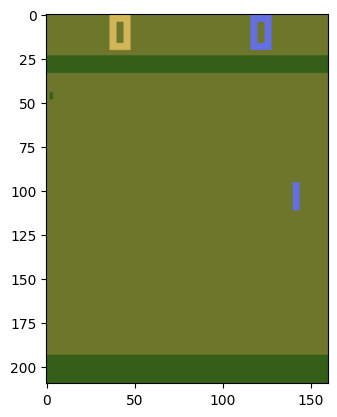

In [15]:
plt.imshow(observation)

In [16]:
num_steps=10000
for step in tqdm(range(num_steps)):
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3

    xs.append(x)
    hs.append(h)
    y = 1 if action == 2 else 0
    dlogps.append(y - aprob)

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    reward_sum += reward
    drs.append(reward)

    if done:
        episode_number += 1

        epx = np.asarray(xs, dtype=np.float32)
        eph = np.asarray(hs, dtype=np.float32)
        epdlogp = np.asarray(dlogps, dtype=np.float32).reshape(-1)
        epr = np.asarray(drs, dtype=np.float32).reshape(-1)

        xs, hs, dlogps, drs = [], [], [], []

        discounted_epr = discount_rewards(epr)
        discounted_epr = (discounted_epr - discounted_epr.mean()) / (discounted_epr.std() + 1e-8)

        epdlogp *= discounted_epr
        grad = policy_backward(eph, epdlogp, epx)

        for k in model:
            grad_buffer[k] += grad[k]

        if episode_number % batch_size == 0:
            for k, v in model.items():
                g = grad_buffer[k]
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v)

        if running_reward is None:
            running_reward = reward_sum
        else:
            running_reward = 0.99 * running_reward + 0.01 * reward_sum

        is_best = running_reward > best_reward
        if is_best:
            best_reward = running_reward

        print(f'Ep {episode_number} | Reward: {reward_sum:+.0f} | Running: {running_reward:.2f} | Best: {best_reward:.2f}')

        if episode_number % 50 == 0:
            save_checkpoint(save_file, is_best=is_best)
            print(f'Checkpoint saved at episode {episode_number}')
        elif is_best:
            save_checkpoint(save_file, is_best=True)
            print(f'New best model saved! Running reward: {running_reward:.2f}')

        reward_sum = 0
        observation, info = env.reset()
        prev_x = None

 12%|████▋                                   | 1169/10000 [00:00<00:06, 1284.97it/s]

Ep 1 | Reward: -21 | Running: -21.00 | Best: -21.00


 19%|███████▍                                | 1864/10000 [00:01<00:06, 1281.62it/s]

Ep 2 | Reward: -21 | Running: -21.00 | Best: -21.00


 27%|██████████▉                             | 2736/10000 [00:02<00:05, 1325.78it/s]

Ep 3 | Reward: -21 | Running: -21.00 | Best: -21.00


 37%|██████████████▉                         | 3744/10000 [00:02<00:04, 1306.24it/s]

Ep 4 | Reward: -21 | Running: -21.00 | Best: -21.00


 49%|███████████████████▌                    | 4903/10000 [00:03<00:04, 1175.76it/s]

Ep 5 | Reward: -20 | Running: -20.99 | Best: -20.99
New best model saved! Running reward: -20.99


 60%|███████████████████████▉                | 5985/10000 [00:04<00:03, 1255.40it/s]

Ep 6 | Reward: -21 | Running: -20.99 | Best: -20.99


 71%|████████████████████████████▍           | 7116/10000 [00:05<00:02, 1183.48it/s]

Ep 7 | Reward: -20 | Running: -20.98 | Best: -20.98
New best model saved! Running reward: -20.98


 82%|████████████████████████████████▉       | 8242/10000 [00:06<00:01, 1257.93it/s]

Ep 8 | Reward: -21 | Running: -20.98 | Best: -20.98


 91%|████████████████████████████████████▍   | 9110/10000 [00:06<00:00, 1320.53it/s]

Ep 9 | Reward: -21 | Running: -20.98 | Best: -20.98


100%|███████████████████████████████████████| 10000/10000 [00:07<00:00, 1304.04it/s]

Ep 10 | Reward: -21 | Running: -20.98 | Best: -20.98


In [21]:
eph.shape

(885, 200)

In [22]:
epdlogp.shape

(885,)

In [23]:
epx.shape

(885, 6400)

---

In [23]:
info

{'lives': 0, 'episode_frame_number': 0, 'frame_number': 0}

In [24]:
cur_x = prepro(observation)

In [25]:
cur_x.shape

(6400,)

In [26]:
x = cur_x - prev_x if prev_x is not None else np.zeros(D) #Gets some temporal info rollin
prev_x = cur_x

In [27]:
aprob, h = policy_forward(x)

In [28]:
aprob

0.5

In [29]:
h.shape

(200,)

In [31]:
aprob, h = policy_forward(x)
action = 2 if np.random.uniform() < aprob else 3

In [38]:
observation, info = env.reset()

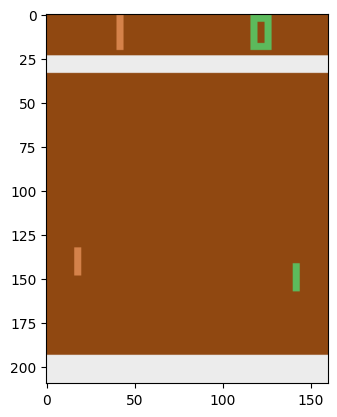

In [104]:
observation, reward, terminated, truncated, info = env.step(1)
plt.imshow(observation)

In [106]:
terminated

False

In [10]:
num_steps=1